In [92]:
from transformers import PretrainedConfig
import torch
import numpy as np
import math
from typing import Optional, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from transformers.models.llama.configuration_llama import LlamaConfig
import seaborn as sns


positional embedding

In [93]:
# Define the RoPE initialization functions
def rope_init_default(config, device=None, **kwargs):
    base = config.rope_base if config else kwargs.get("base", 10000)
    dim = config.hidden_size if config else kwargs.get("dim")
    inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2, device=device).float() / dim))
    attention_scaling = 1.0
    return inv_freq, attention_scaling

def rope_init_2d(config, device=None, **kwargs):
    base = config.rope_base if config else kwargs.get("base", 10000)
    dim = config.hidden_size if config else kwargs.get("dim")
    inv_freq = 1.0 / (base ** (2 * (torch.div(torch.arange(0, dim, 2, device=device), 2, rounding_mode='floor') / dim)))
    attention_scaling = 1.0
    return inv_freq, attention_scaling

def rope_init_standing_wave(config, device=None, **kwargs):
    base = config.rope_base if config else kwargs.get("base", 10000)
    dim = config.hidden_size if config else kwargs.get("dim")
    MAX_HARMONICS = kwargs.get("max_harmonics", 16)
    LINE_LENGTH = kwargs.get("line_length", 2048)
    rate = kwargs.get("rate", 4)
    
    # Original inv_freq
    inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2, device=device).float() / dim))
    
    # Create standing wave frequencies
    harmonics = torch.div(torch.arange(0, dim // 2, device=device), dim // 2 // MAX_HARMONICS, rounding_mode='floor')
    standing_wave = 2 * torch.pi * harmonics / (LINE_LENGTH + torch.randn(dim // 2, device=device) / 8)
    
    # Replace certain frequencies with standing wave frequencies
    inv_freq_sw = inv_freq.clone()
    inv_freq_sw[rate - 1 :: rate] = standing_wave[rate - 1 :: rate]
    
    attention_scaling = 1.0
    return inv_freq_sw, attention_scaling

def rope_init_interleaved(config, device=None, **kwargs):
    base = config.rope_base if config else kwargs.get("base", 10000)
    dim = config.hidden_size if config else kwargs.get("dim")
    rate = kwargs.get("rate", 4)
    
    # Original inv_freq
    inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2, device=device).float() / dim))
    
    # 2D inv_freq
    inv_freq_2d = 1.0 / (base ** (2 * (torch.div(torch.arange(0, dim, 2, device=device), 2, rounding_mode='floor') / dim)))
    
    # Interleave frequencies
    inv_freq_interleaved = inv_freq.clone()
    inv_freq_interleaved[rate - 2 :: rate] = inv_freq_2d[rate - 2 :: rate]
    inv_freq_interleaved[rate - 1 :: rate] = inv_freq_2d[rate - 1 :: rate]
    
    attention_scaling = 1.0
    return inv_freq_interleaved, attention_scaling

# RoPE function registry
ROPE_INIT_FUNCTIONS = {
    "default": rope_init_default,
    "2d": rope_init_2d,
    "standing_wave": rope_init_standing_wave,
    "interleaved": rope_init_interleaved,
}


In [94]:
# Modified LlamaRotaryEmbedding class
class LlamaRotaryEmbedding(nn.Module):
    def __init__(
        self,
        dim=None,
        max_position_embeddings=2048,
        base=10000,
        device=None,
        scaling_factor=1.0,
        rope_type="default",
        config: Optional[LlamaConfig] = None,
        **kwargs,
    ):
        super().__init__()
        self.rope_kwargs = {}
        if config is None:
            self.rope_kwargs = {
                "rope_type": rope_type,
                "factor": scaling_factor,
                "dim": dim,
                "base": base,
                "max_position_embeddings": max_position_embeddings,
            }
            self.rope_type = rope_type
            self.max_seq_len_cached = max_position_embeddings
            self.original_max_seq_len = max_position_embeddings
        else:
            if config.rope_scaling is not None:
                self.rope_type = config.rope_scaling.get("rope_type", config.rope_scaling.get("type"))
            else:
                self.rope_type = "default"
            self.max_seq_len_cached = config.max_position_embeddings
            self.original_max_seq_len = config.max_position_embeddings

        self.config = config
        self.rope_init_fn = ROPE_INIT_FUNCTIONS[self.rope_type]

        # Include any additional arguments
        self.rope_kwargs.update(kwargs)

        inv_freq, self.attention_scaling = self.rope_init_fn(self.config, device, **self.rope_kwargs)
        self.register_buffer("inv_freq", inv_freq, persistent=False)
        self.original_inv_freq = self.inv_freq

        # For 2D RoPE and other variants requiring additional parameters
        self.line_length = kwargs.get("line_length", 2048)
        self.rate = kwargs.get("rate", 4)

    def _dynamic_frequency_update(self, position_ids, device):
        seq_len = torch.max(position_ids) + 1
        if seq_len > self.max_seq_len_cached:
            inv_freq, self.attention_scaling = self.rope_init_fn(
                self.config, device, seq_len=seq_len, **self.rope_kwargs
            )
            self.register_buffer("inv_freq", inv_freq, persistent=False)
            self.max_seq_len_cached = seq_len

        if seq_len < self.original_max_seq_len and self.max_seq_len_cached > self.original_max_seq_len:
            self.register_buffer("inv_freq", self.original_inv_freq, persistent=False)
            self.max_seq_len_cached = self.original_max_seq_len

    def forward(self, x, position_ids):
        if "dynamic" in self.rope_type:
            self._dynamic_frequency_update(position_ids, device=x.device)

        device_type = x.device.type
        device_type = device_type if device_type == "cuda" else "cpu"
        # position_ids is a tensor of shape (batch_size, seq_len)
        with torch.autocast(device_type=device_type, enabled=False):
            if self.rope_type == "2d":
                line_length = self.line_length
                position_ids_x = position_ids % line_length
                position_ids_y = position_ids // line_length

                # (batch_size, seq_len, 2, num_freqs_per_dim)
                position_ids_per_dim = torch.stack((position_ids_x, position_ids_y), dim=-1)
                position_ids_per_dim = position_ids_per_dim.unsqueeze(-1).repeat(1, 1, 1, self.inv_freq.shape[0] // 2) 
                # (batch_size, seq_len, dim // 2)
                position_ids_per_dim = position_ids_per_dim.view(
                    position_ids.shape[0], position_ids.shape[1], self.inv_freq.shape[0]
                )

                freqs = position_ids_per_dim * self.inv_freq.unsqueeze(0).unsqueeze(0)
                emb = torch.cat((freqs, freqs), dim=-1)
                cos = emb.cos()
                sin = emb.sin()
            elif self.rope_type == "standing_wave":
                position_ids_expanded = position_ids[:, :, None].float()
                freqs = position_ids_expanded * self.inv_freq[None, None, :].float()
                emb = torch.cat((freqs, freqs), dim=-1)
                cos = emb.cos()
                sin = emb.sin()
            elif self.rope_type == "interleaved":
                position_ids_expanded = position_ids[:, :, None].float()
                freqs = position_ids_expanded * self.inv_freq[None, None, :].float()
                emb = torch.cat((freqs, freqs), dim=-1)
                cos = emb.cos()
                sin = emb.sin()
            else:
                position_ids_expanded = position_ids[:, :, None].float()
                freqs = position_ids_expanded * self.inv_freq[None, None, :].float()
                emb = torch.cat((freqs, freqs), dim=-1)
                cos = emb.cos()
                sin = emb.sin()

        cos = cos * self.attention_scaling
        sin = sin * self.attention_scaling

        return cos.to(dtype=x.dtype), sin.to(dtype=x.dtype)

In [95]:
# Common configuration
config = LlamaConfig()
config.hidden_size = 64  # Smaller size for visualization
config.max_position_embeddings = 256
config.rope_base = 10000

# Initialize embeddings for different RoPE variants
embedding_default = LlamaRotaryEmbedding(config=config, rope_type="default")
embedding_2d = LlamaRotaryEmbedding(config=config, rope_type="2d", line_length=16)
embedding_sw = LlamaRotaryEmbedding(config=config, rope_type="standing_wave", line_length=16, rate=4)
embedding_interleaved = LlamaRotaryEmbedding(config=config, rope_type="interleaved", line_length=16, rate=4)

# Example input tensors
batch_size = 1
seq_len = 256
position_ids = torch.arange(seq_len).unsqueeze(0).repeat(batch_size, 1)  # shape: (batch_size, seq_len)
x = torch.randn(batch_size, seq_len, config.hidden_size)

cos_default, sin_default = embedding_default(x, position_ids)
cos_2d, sin_2d = embedding_2d(x, position_ids)
cos_sw, sin_sw = embedding_sw(x, position_ids)
cos_interleaved, sin_interleaved = embedding_interleaved(x, position_ids)


In [96]:
def plot_encoding_heatmap(cos_emb, sin_emb, title, dim_range=(0, 16)):
    seq_len = cos_emb.shape[1]
    dims = range(dim_range[0], dim_range[1])
    cos_values = cos_emb[0, :, dims].cpu().numpy()
    sin_values = sin_emb[0, :, dims].cpu().numpy()
    
    encoding = cos_values + sin_values  # Combine for visualization
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(encoding.T, cmap='viridis')
    plt.title(f'{title} - Dimensions {dim_range[0]} to {dim_range[1]-1}')
    plt.xlabel('Position')
    plt.ylabel('Dimension')
    plt.show()



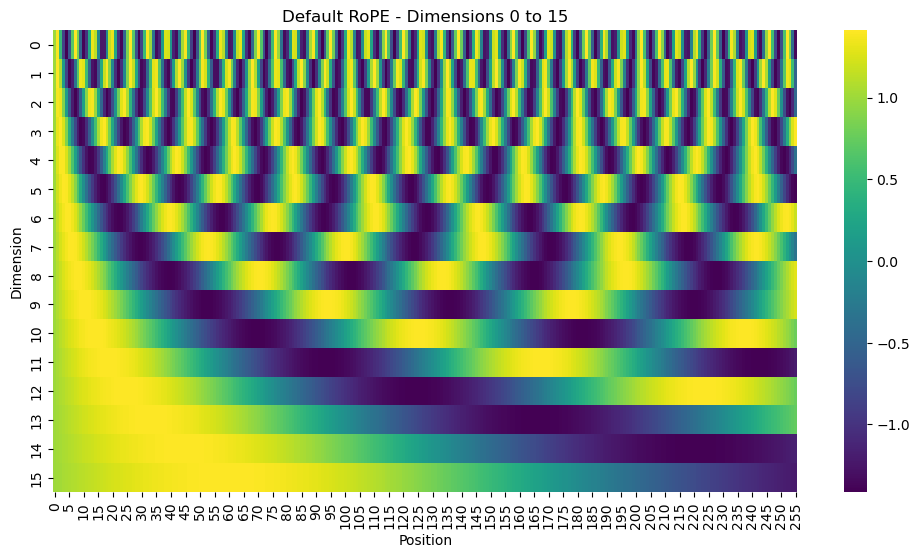

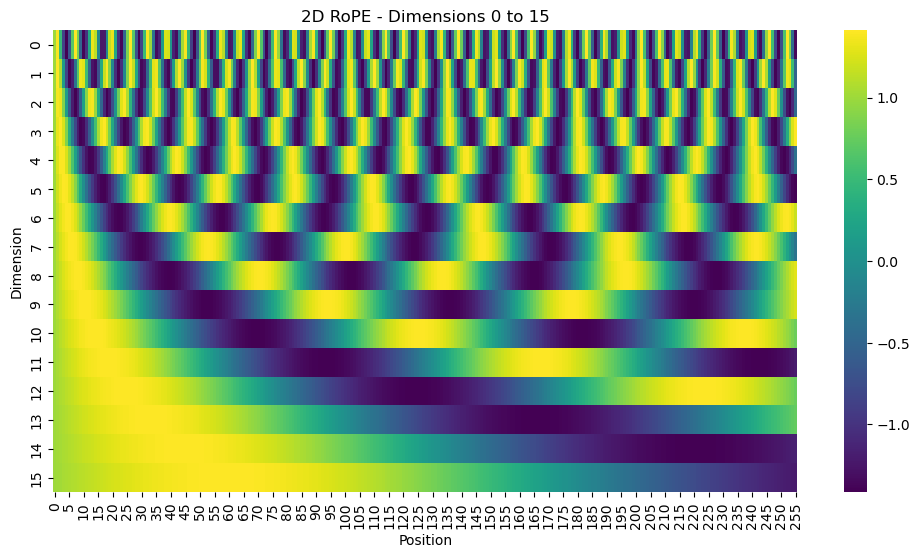

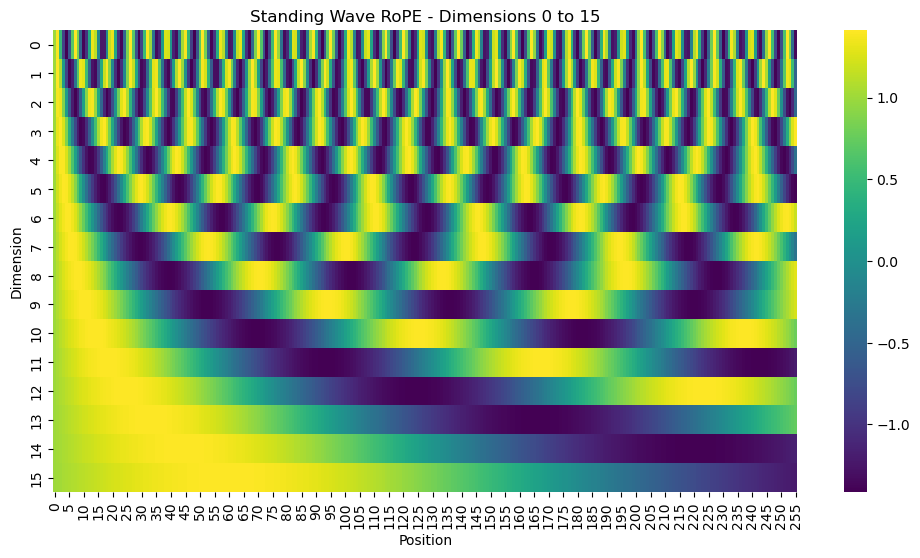

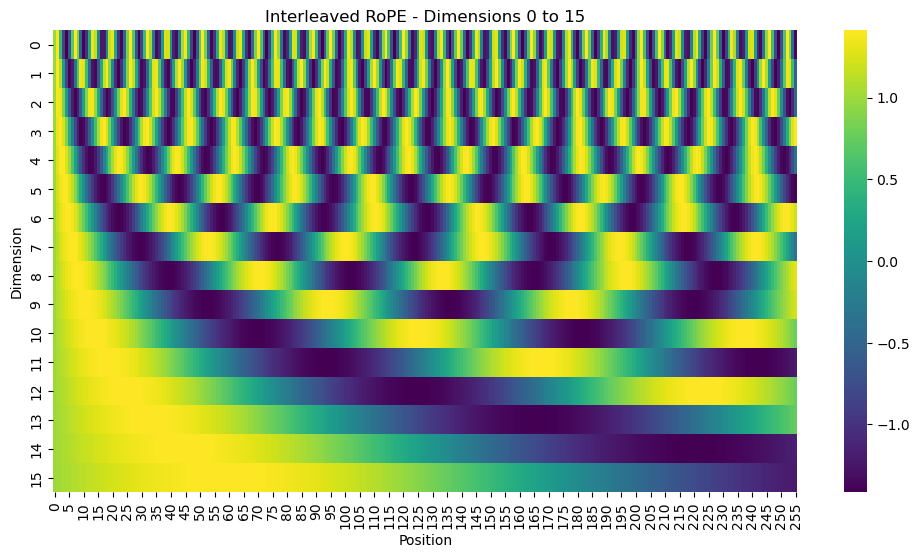

In [97]:
# Dimension range to visualize
dim_range = (0, 16)

# Default RoPE
plot_encoding_heatmap(cos_default, sin_default, 'Default RoPE', dim_range)

# 2D RoPE
plot_encoding_heatmap(cos_2d, sin_2d, '2D RoPE', dim_range)

# Standing Wave RoPE
plot_encoding_heatmap(cos_sw, sin_sw, 'Standing Wave RoPE', dim_range)

# Interleaved RoPE
plot_encoding_heatmap(cos_interleaved, sin_interleaved, 'Interleaved RoPE', dim_range)

